
https://stackoverflow.com/questions/76603587/non-linear-data-fitting-for-kinetic-data

```
solve {x = 1/(1+A+sqrt(s*y/x)), y = 1/(1+A+B +sqrt(s*x/y))} for x and y
```

https://www.wolframalpha.com/input?i=solve+%7Bx+%3D+1%2F%281%2BA%2Bsqrt%28s*y%2Fx%29%29%2C+y+%3D+1%2F%281%2BA%2BB+%2Bsqrt%28s*x%2Fy%29%29%7D+for+x+and+y

```
jacobian {1/(1+B+sqrt(s*y/x)), 1/(1+A+C +sqrt(s*x/y))} wrt x and y
```

https://www.wolframalpha.com/input?i=jacobian+%7B1%2F%281%2BB%2Bsqrt%28s*y%2Fx%29%29%2C+1%2F%281%2BA%2BC+%2Bsqrt%28s*x%2Fy%29%29%7D+wrt+x+and+y

In [1]:
import numpy as np
import pandas as pd
from scipy import optimize 
import matplotlib.pyplot as plt

import logging
import functools

In [2]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [3]:
class Kinetic:
    
    """Langmuir-Hinshelwood Two-Site Kinetic Model Solver"""
    
    R = 8.314              # J/mol.K
    Ea = 37000             # J/mol
    T = 473.15             # K
    theta_ = [0.9, 0.9]    # 1
    
    @staticmethod
    def k3(p, k1, k2, k4, k5, k0):
        """Arrhenius estimation for k3"""
        return k0*np.exp(-Kinetic.Ea/(Kinetic.R*Kinetic.T))

    @staticmethod
    def s(p, k1, k2, k4, k5, k0):
        """Partial kinetic rate"""
        pA, pB, pC = p
        k3 = Kinetic.k3(p, k1, k2, k4, k5, k0)
        return (k1*k2*k3/k4)*pA*pB
    
    @staticmethod
    def equation(x, y, C, s):
        return 1/(1 + C + np.sqrt(s*y/x)) - x
    
    @staticmethod
    def isopleth(x, y, s):
        return (x + np.sqrt(s*x*y) - 1)/x
    
    @staticmethod
    def system(theta, p, k1, k2, k4, k5, k0):
        """Isothermal coverages system"""
        pA, pB, pC = p
        t0, t1 = theta
        s = Kinetic.s(p, k1, k2, k4, k5, k0)
        C0 = k2*pB
        C1 = k1*pA + pC/k5
        return np.array([
            Kinetic.equation(t0, t1, C0, s),
            Kinetic.equation(t1, t0, C1, s),
        ])
    
    @staticmethod
    def _theta(p, k1, k2, k4, k5, k0):
        """Single Isothermal coverages"""
        solution = optimize.fsolve(
            Kinetic.system,
            Kinetic.theta_,
            args=(p, k1, k2, k4, k5, k0),
            full_output=False
        )
        if not(all((solution >= 0.) & (solution <= 1.0))):
            raise ValueError("Theta are not constrained to domain: %s" % solution)
        return solution
    
    @staticmethod
    def theta(p, k1, k2, k4, k5, k0):
        """Isothermal coverages"""
        return np.apply_along_axis(Kinetic._theta, 0, p, k1, k2, k4, k5, k0)
    
    @staticmethod
    def r(p, k1, k2, k4, k5, k0):
        """Global kinetic rate"""
        pA, pB, pC = p
        k3 = Kinetic.k3(p, k1, k2, k4, k5, k0)
        t0, t1 = Kinetic.theta(p, k1, k2, k4, k5, k0)
        return (k1*k2*k3)*pA*pB*t0*t1
    
    @staticmethod
    def solve(p, r, *k):
        """Global kinetic constants adjustment"""
        return optimize.curve_fit(
            Kinetic.r, p.T, r, p0=k,
            bounds=((0, 0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf, np.inf)),
            method="trf",
            gtol=1e-10,
            full_output=True
        )
    
    @staticmethod
    def eval(p, k1, k2, k4, k5, k0):
        return np.vectorize(Kinetic.r, excluded=["p"])(p, k1, k2, k4, k5, k0)
    
    @staticmethod
    def mse(k1, k2, k4, k5, k0, p, r):
        pass
    
    @staticmethod
    def abaque(s, C=None):
        
        lin = np.linspace(0.0001, 1.1, 200)
        X, Y = np.meshgrid(lin, lin)
        if C is None:
            C = np.arange(0, 26, 1)
        
        Cx = Kinetic.isopleth(X, Y, s)
        Cy = Kinetic.isopleth(Y, X, s)
      
        fig, axe = plt.subplots()
        xlabels = axe.contour(X, Y, Cx, C, cmap="jet")
        axe.clabel(xlabels, xlabels.levels, inline=True, fontsize=7)
        ylabels = axe.contour(X, Y, Cy, C, cmap="jet")
        axe.clabel(ylabels, ylabels.levels, inline=True, fontsize=7)
        axe.set_title("Isothemal Coverages System\nConstant Isopleths ($s={}$)".format(s))
        axe.set_xlabel(r"Partial Coverage, $\theta_0$ [-]")
        axe.set_ylabel(r"Partial Coverage, $\theta_1$ [-]")
        axe.set_aspect("equal")
        axe.set_xlim([0, 1.1])
        axe.set_ylim([0, 1.1])
        axe.grid()
        
        return axe

In [4]:
df = pd.read_excel("LangmuirData.xlsx")
df

,pa,pb,pc,T,rate
0,0.10,0.11,0.0114,473.15,0.000001
1,0.13,0.11,0.0121,473.15,0.000002
2,0.20,0.11,0.0170,473.15,0.000004
3,0.25,0.11,0.0172,473.15,0.000004
4,0.30,0.11,0.0252,473.15,0.000005
5,0.35,0.11,0.0261,473.15,0.000006
6,0.10,0.16,0.0123,473.15,0.000003
7,0.10,0.20,0.0172,473.15,0.000004
8,0.10,0.22,0.0181,473.15,0.000003
9,0.10,0.33,0.0221,473.15,0.000005


In [5]:
p = df.filter(regex="p").values
r = df["rate"].values

In [6]:
Kinetic.solve(p, r, 5, 1e5, 50, 10, 100)

(array([1.39075854e-01, 2.15668993e+03, 1.16513471e+00, 2.69648513e-01,
        2.64057386e+00]),
 array([[ 1.48622028e+03, -6.20830186e+06,  2.86587881e+05,
          1.03973854e+02, -2.89149484e+04],
        [-6.20830186e+06,  1.73740772e+12, -3.36688691e+09,
          9.40415116e+06,  1.17499454e+08],
        [ 2.86587881e+05, -3.36688691e+09,  5.84376597e+07,
          5.50069835e+03, -5.57235249e+06],
        [ 1.03973854e+02,  9.40415116e+06,  5.50069835e+03,
          8.40397226e+01, -2.04455154e+03],
        [-2.89149484e+04,  1.17499454e+08, -5.57235249e+06,
         -2.04455154e+03,  5.62563731e+05]]),
 {'nfev': 10,
  'fvec': array([ 1.63900711e-06,  1.66564630e-06,  1.55523211e-06,  2.83708013e-06,
          2.40778598e-06,  2.85927736e-06,  3.37890387e-08, -1.19231145e-06,
         -4.03211541e-07, -2.37714019e-06, -3.98891395e-06])},
 '`gtol` termination condition is satisfied.',
 1)

In [7]:
#Kinetic.solve(p, r, 1, 1, 1, 1, 1)

In [8]:
#Kinetic.solve(p, r, 1e2, 1e2, 1e2, 1e2, 1e2)

In [9]:
plin = np.linspace(0.1, 0.3, 5)
PA, PB, PC = np.meshgrid(plin, plin, plin)

In [10]:
P = np.vstack([
    PA.flatten(), PB.flatten(), PC.flatten()
]).T

In [105]:
R = Kinetic.r(P.T, 5, 1e5, 50, 10, 100)
R += np.random.randn(R.shape[0])*1e-7

In [106]:
R.shape

(125,)

In [107]:
Kinetic.solve(P, R, 1e2, 1e2, 1e2, 1e2, 1e2)

(array([   4.86118569, 2554.54531389,    8.13767002,    9.99495037,
         104.4230975 ]),
 array([[ 1.15491885e-02,  2.91862924e+00,  8.06566538e-01,
         -8.55253176e-04, -3.60785930e-01],
        [ 2.91862924e+00,  5.37311734e+04,  2.04365118e+02,
         -6.64542036e-02, -9.62500756e+01],
        [ 8.06566538e-01,  2.04365118e+02,  5.64766277e+01,
         -1.83698961e-02, -2.52442933e+01],
        [-8.55253176e-04, -6.64542036e-02, -1.83698961e-02,
          6.00377228e-02,  8.44654093e-03],
        [-3.60785930e-01, -9.62500756e+01, -2.52442933e+01,
          8.44654093e-03,  1.12871418e+01]]),
 {'nfev': 158,
  'fvec': array([-3.70050974e-06, -3.67714037e-06, -3.58109037e-06, -3.49657776e-06,
         -3.47086215e-06, -5.77026946e-06, -6.00756332e-06, -5.72591314e-06,
         -5.66568969e-06, -5.81830402e-06, -6.75302542e-06, -6.72449394e-06,
         -6.45728099e-06, -6.63302127e-06, -6.82668578e-06, -7.23979388e-06,
         -7.06895663e-06, -7.11566663e-06, -7.07452550

In [108]:
Kinetic.solve(P, R, 1e4, 1e4, 1e4, 1e4, 1e4)

(array([   4.60027101, 1432.10927392,    1.80536374,   10.00113111,
         113.31636563]),
 array([[ 3.28470816e-02,  4.78771602e+00,  2.39880312e-01,
         -2.56195352e-03, -1.16665338e+00],
        [ 4.78771602e+00,  1.81843482e+04,  3.50593728e+01,
         -1.16584904e-01, -1.75946539e+02],
        [ 2.39880312e-01,  3.50593728e+01,  1.75659780e+00,
         -5.83998165e-03, -8.53646672e+00],
        [-2.56195352e-03, -1.16584904e-01, -5.83998165e-03,
          1.88812166e-01,  2.92311605e-02],
        [-1.16665338e+00, -1.75946539e+02, -8.53646672e+00,
          2.92311605e-02,  4.14977667e+01]]),
 {'nfev': 126,
  'fvec': array([-5.86392998e-06, -5.79863674e-06, -5.66086104e-06, -5.53482117e-06,
         -5.46777701e-06, -1.05225078e-05, -1.07300859e-05, -1.04186497e-05,
         -1.03285739e-05, -1.04512735e-05, -1.23780173e-05, -1.23380732e-05,
         -1.20591702e-05, -1.22229488e-05, -1.24043857e-05, -1.27081532e-05,
         -1.25435649e-05, -1.25961155e-05, -1.25604128

In [109]:
Kinetic.solve(P, R, 1, 1, 1, 1, 1)

(array([5.00068352e+00, 1.13206833e+05, 5.08728959e+01, 9.99182652e+00,
        9.99777726e+01]),
 array([[ 8.35438771e-06,  7.13582594e-02,  9.11688421e-03,
         -6.01615638e-07, -2.43864631e-04],
        [ 7.13582594e-02,  1.35760924e+08,  8.14164370e+01,
          2.07866611e-03, -8.29515558e+00],
        [ 9.11688421e-03,  8.14164370e+01,  9.97470501e+00,
         -1.99217705e-04, -2.66624450e-01],
        [-6.01615638e-07,  2.07866611e-03, -1.99217705e-04,
          4.12949379e-05,  5.47549582e-06],
        [-2.43864631e-04, -8.29515558e+00, -2.66624450e-01,
          5.47549582e-06,  7.12885021e-03]]),
 {'nfev': 176,
  'fvec': array([-1.71852134e-08, -2.39440964e-08,  4.21341318e-08,  9.68311208e-08,
          9.28868619e-08, -1.47817469e-08, -2.76673008e-07, -1.96055815e-08,
          1.60514111e-08, -1.61111516e-07,  2.05616044e-09,  1.52502781e-08,
          2.67029469e-07,  7.57616186e-08, -1.33521738e-07, -1.36739155e-07,
          2.79271294e-08, -2.51217168e-08,  9.515

In [145]:
N = 50
k1, k2, k4, k5, k0 = 5, 1e5, 50, 10, 100
k1l = np.logspace(-2, 2, N, base=10)
k2l = np.logspace(3, 7, N, base=10)
k4l = np.logspace(-3, 3, N, base=10)
k5l = np.logspace(0, 4, N, base=10)
k0l = np.logspace(1, 6, N, base=10)

In [146]:
partial = functools.partial(Kinetic.r, P.T)
vectorized = np.vectorize(partial, otypes=[np.ndarray])

def error(y):
    def wrapped(yhat):
        return np.log10(np.sum((y-yhat)**2)/y.size)
    return wrapped

In [147]:
K1, K2 = np.meshgrid(k1l, k2l)
K1, K4 = np.meshgrid(k1l, k4l)
K1, K5 = np.meshgrid(k1l, k5l)
K1, K0 = np.meshgrid(k1l, k0l)

In [148]:
K4, K0 = np.meshgrid(k4l, k0l)


In [149]:
Rk = vectorized(k1, k2, K4, k5, K0)
mse = np.vectorize(error(R))
MSEk = mse(Rk)

/tmp/ipykernel_1285/3908429210.py:24: RuntimeWarning: invalid value encountered in sqrt
  return 1/(1 + C + np.sqrt(s*y/x)) - x
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


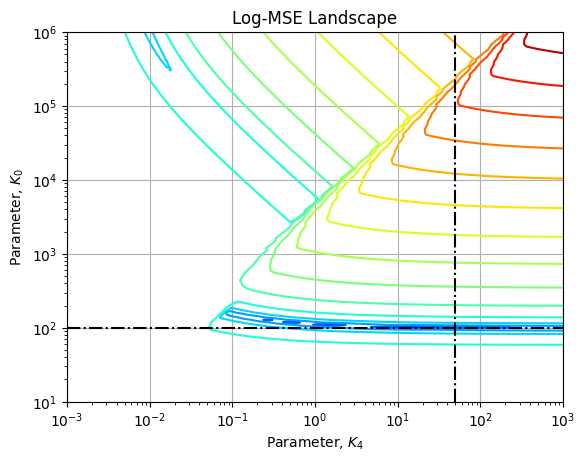

In [150]:
fig, axe = plt.subplots()
axe.contour(K4, K0, MSEk, 20, cmap="jet")
axe.axvline(k4, linestyle="-.", color="black")
axe.axhline(k0, linestyle="-.", color="black")
axe.set_xscale("log")
axe.set_yscale("log")
axe.set_title("Log-MSE Landscape")
axe.set_xlabel("Parameter, $K_4$")
axe.set_ylabel("Parameter, $K_0$")
axe.grid()